In [9]:
import sys
from multiprocessing.forkserver import connect_to_new_process

from exam.ordinary_exam_2022.solution_ordinary_exam_2022 import df_weights

sys.path.insert(0,'C:\\Users\\madsn\\PycharmProjects\\FinEcon\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import datetime

from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag, eigvals

import cvxpy as cp

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
import codelib.portfolio_optimization.risk_metrics as rm
import codelib.portfolio_optimization.diversification as dm

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.portfolio_optimization.mean_variance import portfolio_mean, portfolio_std, portfolio_variance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#define inputs

corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / 100
mu = np.array([3.2, 3.12, 8.0, 8.2]) / 100

cov_mat = corr_to_cov_matrix(corr_mat, vols)


In [11]:
#define and solve problem

num_assets = len(mu)

w0 = np.ones(num_assets) / num_assets #equal weigh funktion
delta = 0.045 #given in question describtion ( required return of 4,5%)

#definition of optimazation variable. change in weights (sell/ buy to keep equal weights)
x = cp.Variable(num_assets)

#constraints
constraints = [cp.sum(x) == 0.0, (w0 + x) @ mu >= delta] #[cp.sum(x) == 0.0] = fully invested [(w0 +x) @ mu >= delta] = target return

# define problem
prob = cp.Problem(cp.Minimize(cp.quad_form(x + w0, cov_mat)),
                              constraints=constraints)

prob.solve()

x.value

array([ 0.3973821 , -0.16023989, -0.21445942, -0.0226828 ])

In [12]:
w0 + x.value # new allocation in assets

array([0.6473821 , 0.08976011, 0.03554058, 0.2273172 ])

interpertation.
hevely increase asset 1 (low vol, low return) if we had stayed in equal weight E[R] = 5.63%, sigma = 12.1%. optimal portfolio = E[R]= 4.5% sigma= 8.1% so decresed risk and exp return.

In [13]:
num_assets = len(mu)

w0 = np.ones(num_assets) / num_assets
delta = 0.045

#transaction cost
alpha_pos = 0.01
alpha_neg = -0.01

#define opt variable
x = cp.Variable(num_assets)
x_pos = cp.Variable(num_assets)
x_neg = cp.Variable(num_assets)

constraints = [x_pos >= 0.0,
               x_neg >= 0.0,
               cp.sum(x + alpha_pos*x_pos + alpha_pos * x_neg) <= 0.0,
               x == x_pos - x_neg,
               (w0 + x) @ mu >= delta]

prob = cp.Problem(cp.Minimize(cp.quad_form(x + w0, cov_mat)),
                              constraints=constraints)

prob.solve()

x.value

array([ 0.25323061, -0.02672553, -0.21168337, -0.01993748])

In [14]:
w0 + x.value

array([0.50323061, 0.22327447, 0.03831663, 0.23006252])

Problem 2

In [15]:
asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100

# number of assets
num_assets = len(mu)

In [16]:
#minimum varians port

sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) -1.0,
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat

x0 = np.ones_like(mu) / len(mu)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        jac=port_var_der,
                        constraints=[sum_to_one_cons, no_short_cons],
                        options={'ftol': 1e-9, 'disp': True})

w_min_var = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.001021415810333775
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34


In [17]:
w_min_var.round(2)

array([ 0.8 ,  0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.03,  0.07,
        0.1 ])

In [18]:
w_min_var

array([ 8.02734800e-01,  4.92225486e-17, -8.47065919e-19,  7.07298892e-19,
        1.12143471e-18,  2.17709675e-19, -2.35953956e-18,  3.12867574e-02,
        6.91822254e-02,  9.67962176e-02])

calculation only conserne to minimize variance and does not take expected return into consideration. 

Q2

In [19]:
dm.calculate_enc(w_min_var, alpha=1)

np.float64(0.0)

In [20]:
dm.calculate_enc(w_min_var, alpha=2)

np.float64(1.5162595153787515)

Q3

In [21]:
eq_weigts = np.ones(num_assets) / num_assets

In [22]:
eigvals, eigvec = np.linalg.eigh(cov_mat)

idx = np.argsort(-eigvals)
pca_mat = eigvec[:, idx]
factor_variance = eigvals[idx]

In [23]:
#minimum variance

dm.calculate_enb(w_min_var, transition_matrix=pca_mat,
                 factor_variances=factor_variance, alpha=2)

(np.float64(5.0029715450899985),
 array([0.10401501, 0.02823357, 0.06798733, 0.13280279, 0.06837737,
        0.01591043, 0.01491868, 0.0520781 , 0.37004699, 0.14562972]))

In [24]:
dm.calculate_enb(eq_weigts, transition_matrix=pca_mat,
                 factor_variances=factor_variance, alpha=2)

(np.float64(1.0694641828489257),
 array([9.66799728e-01, 8.20732679e-08, 8.89513681e-03, 1.48804751e-02,
        6.51427714e-03, 6.35375267e-04, 3.18319625e-05, 8.20989557e-04,
        1.37645679e-03, 4.56473786e-05]))

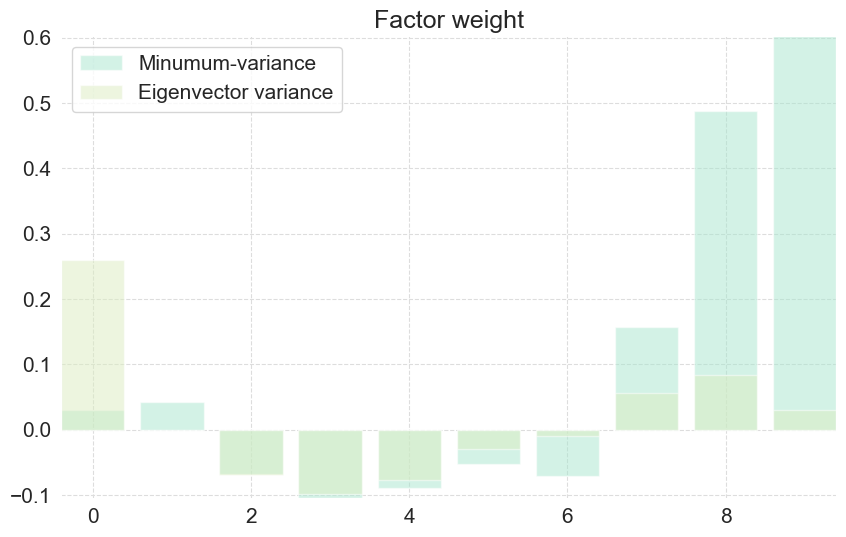

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(num_assets), pca_mat.T @ w_min_var, alpha=0.5, label='Minumum-variance')
ax.bar(range(num_assets), pca_mat.T @ eq_weigts, alpha=0.5, label='Eigenvector variance')
ax.set_title('Factor weight')
ax.legend();

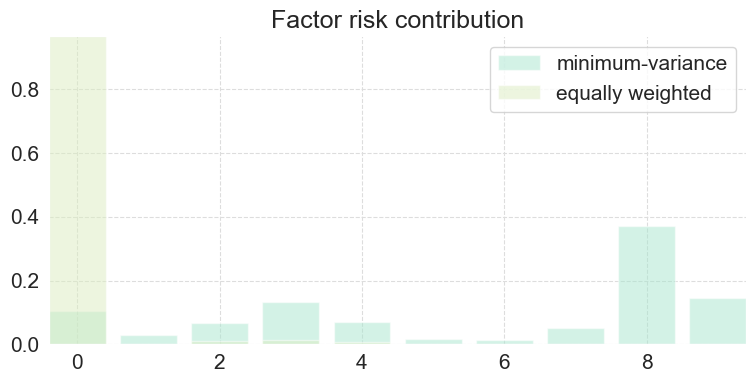

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))

ax.bar(range(num_assets), dm.calculate_enb(w_min_var, transition_matrix=pca_mat,
                                           factor_variances=factor_variance, alpha=2)[1],
                                            alpha=0.5, label='minimum-variance')

ax.bar(range(num_assets), dm.calculate_enb(eq_weigts, transition_matrix=pca_mat,
                                           factor_variances=factor_variance, alpha=2)[1],
                                            alpha=0.5, label ='equally weighted')

ax.set_title('Factor risk contribution')
ax.legend();

Question 4


In [27]:
"""
Find minimum variance portfolio
"""

enb_target = 8.0

#define common constraints

sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) -1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

number_of_bets = {'type': 'ineq',
                  'fun' : lambda x: dm.calculate_enb(x, pca_mat, factor_variances=factor_variance,
                   alpha=2)[0] - enb_target}

x0 = np.ones_like(mu) / len(mu)

res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        constraints=[sum_to_one_cons, number_of_bets, no_short_cons],
                        options={'ftol': 1e-10, 'disp': True})

w_min_var_enb = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.001299998265312989
            Iterations: 90
            Function evaluations: 1023
            Gradient evaluations: 90


In [28]:
w_min_var_enb.round(2)

array([ 0.73, -0.  , -0.  ,  0.12,  0.  , -0.  ,  0.  ,  0.03,  0.11,
        0.01])

In [29]:
w_min_var.round(2)

array([ 0.8 ,  0.  , -0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.03,  0.07,
        0.1 ])

In [30]:
dm.calculate_enb(w_min_var_enb, transition_matrix=pca_mat, factor_variances=factor_variance, alpha=2)

(np.float64(7.999999999999914),
 array([0.13883027, 0.08190363, 0.08955096, 0.13659538, 0.11194516,
        0.05669121, 0.06439373, 0.0179762 , 0.20801592, 0.09409755]))

spg 3 q1

In [31]:
"""
Define inputs
"""

asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100

# number of assets
num_assets = len(mu)

# risk aversion
lam = 1.0

In [32]:
def calculate_mvo(mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0, solver='OSQP'):

    #number of assets
    num_assets = len(mu)

    #define port wieght to optimize over
    w = cp.Variable(num_assets)

    # define mean variance objective
    objective = w @ mu - 0.5*lam * cp.quad_form(w, cov_mat)

    #define problem
    problem = cp.Problem(cp.Maximize(objective), constraints=[w>=0.0, cp.sum(w)==1.0])

    #solbe problem
    problem.solve(solver=solver)

    return w.value


In [33]:
def calculate_ceq(w: np.ndarray, mu: np.ndarray, cov_mat: np.ndarray, lam: float = 5.0):

    mu_port = portfolio_mean(w, mu)
    var_port = portfolio_variance(w, cov_mat)
    ceq = mu_port - 0.5 * lam * var_port

    return ceq

In [70]:
def calculate_loss(mu: np.ndarray, cov_mat: np.ndarray, w: np.ndarray, lam: float = 5.0):



      w_true = calculate_mvo(mu, cov_mat, lam)
      mu_port_true = portfolio_mean(w_true, mu)
      var_port_true = portfolio_variance(w_true, cov_mat)
      ceq_true = mu_port_true - 0.5 * lam * var_port_true

      mu_port_est = portfolio_mean(w, mu)
      var_port_est = portfolio_variance(w, cov_mat)
      ceq_est = mu_port_est - 0.5 * lam * var_port_est

      loss = ceq_true - ceq_est

      return loss

In [35]:
w_mvo = calculate_mvo(mu, cov_mat, lam=5.0)
df_weights = pd.DataFrame({'MVO': w_mvo}, index=asset_names)

In [36]:
df_weights

,MVO
Government bonds,3.780690e-01
Investment-grade bonds,9.313552e-23
High-yield bonds,-2.398472e-24
Emerging markets gov. bonds,6.247167e-02
Equities (developed markets),1.313839e-22
Equities (Emerging markets),-9.336993e-23
Private equity,3.424500e-01
Infrastructure,1.646819e-01
Real Estate,5.232748e-02
Hedgefunds,2.624293e-23


In [38]:
def calculate_naive_risk_parity(vols: np.ndarray) -> np.ndarray:

    inv_vols = 1.0 / vols
    sum_inv_vols = np.sum(inv_vols)

    w_iv = inv_vols / sum_inv_vols

    return  w_iv

In [48]:
def calculate_risk_parity(cov_mat: np.ndarray) -> np.ndarray:

    num_assets = cov_mat.shape[0]

    w = cp.Variable(num_assets)

    b = 1.0 / num_assets
    c = 0.1

    constraints = [w >= 0.0001,
                   cp.sum(b * cp.log(w)) >= c]

    prob = cp.Problem(cp.Minimize(0.5 * cp.quad_form(w, cov_mat)), constraints=constraints)

    prob.solve()

    return w.value / w.value.sum()

def calculate_minimum_variance(cov_mat: np.ndarray) -> np.ndarray:

    num_assets = cov_mat.shape[0]

    w = cp.Variable(num_assets)
    constraints = [cp.sum(w)==1.0, w>=0.0]

    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    prob.solve()
    if prob.status == 'optimal':
        return w.value
    else:
        prob.solve(solver='SCS')
        return w.value

In [40]:
def calculate_cc_ratio(weights: np.ndarray, cov_mat: np.ndarray):

    port_std = rm.calculate_portfolio_std(weights=weights, cov_mat=cov_mat)

    vol_vec = np.sqrt(np.diag(cov_mat))
    avg_std = np.inner(weights, vol_vec)

    return avg_std / port_std

In [44]:
def calculate_most_diversified_portfolio(cov_mat: np.ndarray, init_weights=None) -> np.ndarray:

    n = cov_mat.shape[0]
    if init_weights is None:
        init_weights = np.repeat(1.0 / n, n)

    eq_constraint = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    res = optimize.minimize(lambda x: -calculate_cc_ratio(x, cov_mat) * 100 * 100, init_weights,
                            constraints=[eq_constraint], bounds=[(0.0, 1.0)]*n)

    return res.x

In [50]:
def calculate_minimum_variance_norm(cov_mat: np.ndarray, delta: float) -> np.ndarray:

    num_assets = cov_mat.shape[0]

    w = cp.Variable(num_assets)

    constraints = [cp.sum(w)==1.0, w>=0.0,
                   cp.quad_form(w, np.eye(num_assets)) <= delta]

    prob = cp.Problem(cp.Minimize(w @ cov_mat @ w), constraints=constraints)

    try:
        prob.solve()
    except:
        prob.solve(solver='SCS')

    return w.value

In [53]:
# calculate risk based portfolios using true parm

w_min_var = calculate_minimum_variance(cov_mat)
df_weights['MIN-VARIANCE'] = w_min_var

w_min_var_norm = calculate_minimum_variance_norm(cov_mat, 0.2)
df_weights['NAIVE-RP'] = w_min_var_norm

w_naive_rp = calculate_naive_risk_parity(vols)
df_weights['NAIVE-RP'] = w_naive_rp

w_rp = calculate_risk_parity(cov_mat)
df_weights['RISK-PARITY'] = w_rp

w_most_div = calculate_most_diversified_portfolio(cov_mat)
df_weights['MOST-DIV'] = w_most_div

df_weights['EQ'] = np.ones(num_assets) / num_assets

In [54]:
df_weights

,MVO,MIN-VARIANCE,NAIVE-RP,RISK-PARITY,MOST-DIV,EQ
Government bonds,3.780690e-01,8.027342e-01,0.254865,0.405036,6.964223e-01,0.1
Investment-grade bonds,9.313552e-23,-2.198261e-21,0.171454,0.141304,0.000000e+00,0.1
High-yield bonds,-2.398472e-24,1.220118e-21,0.079244,0.051199,0.000000e+00,0.1
Emerging markets gov. bonds,6.247167e-02,-4.773792e-22,0.088131,0.062707,2.664763e-08,0.1
Equities (developed markets),1.313839e-22,3.696692e-21,0.061634,0.043486,0.000000e+00,0.1
Equities (Emerging markets),-9.336993e-23,5.266630e-21,0.043456,0.031716,1.370132e-02,0.1
Private equity,3.424500e-01,5.216343e-21,0.046225,0.035735,5.667836e-02,0.1
Infrastructure,1.646819e-01,3.133456e-02,0.067357,0.068141,8.777983e-02,0.1
Real Estate,5.232748e-02,6.921314e-02,0.087315,0.089979,1.137887e-01,0.1
Hedgefunds,2.624293e-23,9.671807e-02,0.100319,0.070696,3.162980e-02,0.1


In [55]:
df_ceq_true = df_weights.apply(calculate_ceq, axis=0, args=(mu, cov_mat, lam))

In [56]:
df_ceq_true

MVO             0.052466
MIN-VARIANCE    0.023009
NAIVE-RP        0.037585
RISK-PARITY     0.033867
MOST-DIV        0.030241
EQ              0.047330
dtype: float64

In [77]:
num_sim = 1000
sample_size = 120

sim_mu = stats.multivariate_normal.rvs(mean=mu, cov=cov_mat / sample_size, size=num_sum)
sim_cov_mat = stats.wishart.rvs(df = sample_size-1, scale = cov_mat / sample_size, size = num_sum)
sim_corr_mat = np.array([cov_to_corr_matrix(sim_cov_mat[i]) for i in range(num_sum)])

In [78]:
sim_w_min_var = np.array([calculate_minimum_variance(sim_cov_mat[i]) for i in range(num_sim)])
sim_w_min_var_norm = np.array([calculate_minimum_variance_norm(sim_cov_mat[i], 0.2) for i in range(num_sim)])
sim_w_naive_rp = np.array([calculate_naive_risk_parity(np.sqrt(np.diag(sim_cov_mat[i]))) for i in range(num_sim)])
sim_w_rp = np.array([calculate_risk_parity(sim_cov_mat[i]) for i in range(num_sim)])
sim_w_most_div = np.array([calculate_most_diversified_portfolio(sim_cov_mat[i]) for i in range(num_sim)])

In [79]:
sim_loss_min_var = np.array([calculate_loss(mu, cov_mat, sim_w_min_var[i], lam) for i in range(num_sim)])
sim_loss_min_var_norm = np.array([calculate_loss(mu, cov_mat, sim_w_min_var_norm[i], lam) for i in range(num_sim)])
sim_loss_naive_rp = np.array([calculate_loss(mu, cov_mat, sim_w_naive_rp[i], lam) for i in range(num_sim)])
sim_loss_rp = np.array([calculate_loss(mu, cov_mat, sim_w_rp[i], lam) for i in range(num_sim)])
sim_loss_most_div = np.array([calculate_loss(mu, cov_mat, sim_w_most_div[i], lam) for i in range(num_sim)])

In [80]:
w_eq = np.ones(num_assets) / num_assets
loss_eq = calculate_loss(mu, cov_mat, w_eq, lam)

In [81]:
sim_loss_rp.shape

(1000,)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

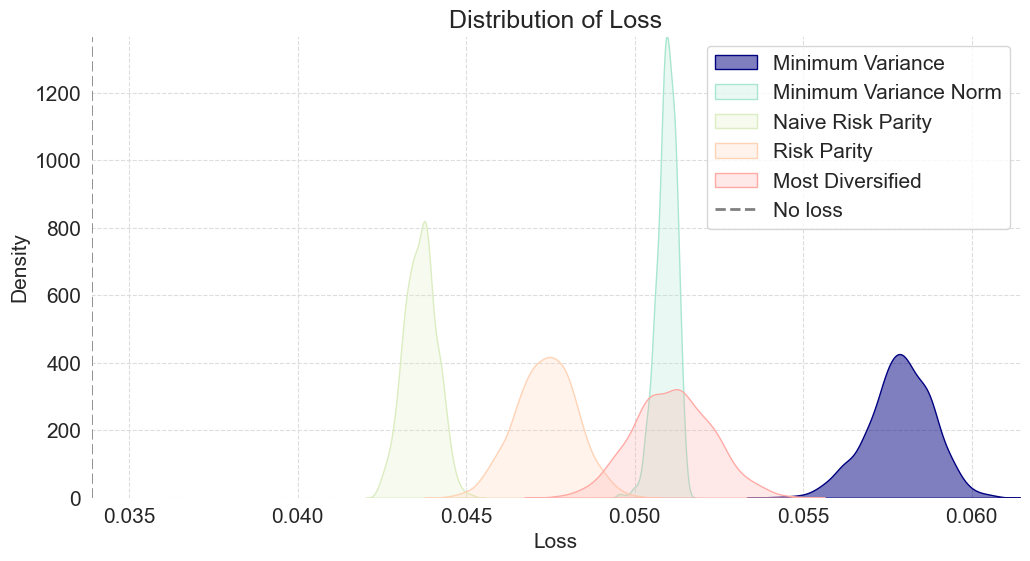

In [82]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(sim_loss_min_var, fill=True, ax=ax, color="navy", alpha=0.5, label="Minimum Variance")
sns.kdeplot(sim_loss_min_var_norm, fill=True, ax=ax, label="Minimum Variance Norm")
sns.kdeplot(sim_loss_naive_rp, fill=True, ax=ax, label="Naive Risk Parity")
sns.kdeplot(sim_loss_rp, fill=True, ax=ax, label="Risk Parity")
sns.kdeplot(sim_loss_most_div, fill=True, ax=ax, label="Most Diversified")

ax.axvline(x=loss_eq, color='gray', linestyle='--', label="No loss")

ax.legend()
ax.set_title("Distribution of Loss")
ax.set_xlabel("Loss")
ax.set_ylabel("Density")

plt.tight_layout